In [80]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
# import ray
# ray.init(num_cpus=4)
# import modin.pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
import gc
import category_encoders as ce
import lightgbm as lgb
from sklearn.decomposition import PCA

from utils.schemas import *
from utils.functions import *

In [3]:
data_folder = 'input'

In [4]:
train = pd.read_csv(data_folder+'/train_generated_4.csv', dtype = schema_generated_4)#.sort_values('TransactionDT')
test = pd.read_csv(data_folder+'/test_generated_4.csv', dtype = schema_generated_4)#.sort_values('TransactionDT')

In [5]:
train.shape, test.shape

((590540, 538), (506691, 538))

In [6]:
train_index = train.shape[0]
test_index = test.shape[0]
df = pd.concat([train, test], axis=0)
df.shape
# del train, test
gc.collect()

7

In [7]:
old_cols = df.columns

In [8]:
# groups V
cols1 = ['V{}'.format(x) for x in range(1,12)]
cols2 = ['V{}'.format(x) for x in range(12,35)]
cols3 = ['V{}'.format(x) for x in range(35,53)]
cols4 = ['V{}'.format(x) for x in range(53,75)]
cols5 = ['V{}'.format(x) for x in range(75,95)]
cols6 = ['V{}'.format(x) for x in range(95,138)]
cols7 = ['V{}'.format(x) for x in range(138,167)]
cols8 = ['V{}'.format(x) for x in range(167,217)]
cols9 = ['V{}'.format(x) for x in range(217,279)]
cols10 = ['V{}'.format(x) for x in range(279,322)]
cols11 = ['V{}'.format(x) for x in range(322,340)]

In [9]:
# Binary V
bin_v = ['V1', 'V14', 'V41', 'V65', 'V88', 'V107', 'V305']

In [10]:
V_cols = [cols1, cols2, cols3, cols4, cols5, cols6, cols7, cols8, cols9, cols10, cols11, bin_v]

In [11]:
def freq_encoder2(df, label, min_freq = 0.001):
    rows = df.shape[0]
    n = 0
    dict_fe = dict()
    vc = df[label].value_counts()
    for i, j in zip(vc.index, vc):
        ratio = j/rows
        if ratio > min_freq:
            dict_fe[i] = n
            n += 1
        else:
            dict_fe[i] = n

    if n < 2**8:
        _d_type = 'uint8'
    elif n >= 2**8 and n < 8**16:
        _d_type = 'uint16'
    elif n >= 2**16 and n < 8**32:
        _d_type = 'uint32'
    else:
        _d_type = 'uint64'

#     df[new_label] = df[label].apply(lambda x: dict_fe[x]).astype(_d_type)

    return dict_fe, _d_type

def freq_encoder2_test(df, label, dict_fe):
    list_unique = df[label].unique()
    max_val = max(dict_fe.values())
    train_values = dict_fe.keys()
    for v in list_unique:
        if v not in train_values:
            dict_fe[v] = max_val+1
    
    return dict_fe

In [12]:
def reduce_memory2(df):
    print("Reduce_memory...");
    dict_types = dict()
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dict_types[col] = 'int8'
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dict_types[col] = 'int16'
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dict_types[col] = 'int32'
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dict_types[col] = 'int64'
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dict_types[col] = 'float16'
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dict_types[col] = 'float32'
                else:
                    dict_types[col] = 'float64'
    return dict_types


In [43]:
def plot_col(df, col, scat=True):
    if scat:
        fig, ax = plt.subplots()
        fig.set_size_inches(15, 6)
        ax.scatter(df[df.isFraud == 0].TransactionDT, df[df.isFraud == 0][col])
        ax.scatter(df[df.isFraud == 1].TransactionDT, df[df.isFraud == 1][col])
        ax.scatter(df[df.isFraud.isna()].TransactionDT, df[df.isFraud.isna()][col])
    else:
        fig, ax = plt.subplots()
        fig.set_size_inches(15, 6)
        ax.plot(df[df.isFraud == 0].TransactionDT, df[df.isFraud == 0][col])
        ax.plot(df[df.isFraud == 1].TransactionDT, df[df.isFraud == 1][col])
        ax.plot(df[df.isFraud.isna()].TransactionDT, df[df.isFraud.isna()][col])
    plt.show()
    gc.collect()

In [14]:
def plot_hist_col(df, col):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 6)
    ax.hist(df[df.isFraud.isna()][col], 100)
    ax.hist(df[df.isFraud == 0][col], 100)
    ax.hist(df[df.isFraud == 1][col], 100)
    plt.show()
    gc.collect()

In [158]:
def micro_train(X_fit, y_fit, X_val, y_val):
    params = {
#     'num_leaves': 256,
    'max_depth': 9,
#     'max_leaf_nodes': 45,
#     'min_sample_leaf': 20,
    'metric': ['AUC'],
    'first_metric_only': True,
    'n_estimators': 50000,
    'num_threads': 8,
    'learning_rate': 0.01,
    'colsample_bytree': 0.5,
    'objective': 'xentropy',
    'bagging_fraction': 0.5,
    'bagging_freq': 5,
    'importance_type': 'gain',
    'bagging_seed': 42,
    'random_state':42,
    'seed': 42,
    'feature_fraction_seed': 42,
    'drop_seed': 42,
    'data_random_seed': 42,
    }
    model = lgb.LGBMClassifier(**params)
    model.fit(X_fit, y_fit, eval_set=[(X_val, y_val), (X_fit, y_fit)],
         early_stopping_rounds=50, verbose=50)
    
    df_importances = pd.DataFrame({'feature': X_fit.columns, 'importance': model.feature_importances_})\
    .sort_values('importance', ascending=False).reset_index(drop=True)
    
    return df_importances

In [16]:
df['addr'] = df.addr1.astype(str) + df.addr2.astype(str)

In [17]:
first_drop_col = ['D9','id_24','id_25','id_07','id_08','id_21','id_26','id_27','id_23','id_22','dist2']

In [18]:
cols_v = [x for x in train.columns if 'V' in x]

In [121]:
drop_cols = ['TransactionDT', 'date', 'day', 'isFraud', 'month', 'date_fe1',
#              'addr1',
#              'addr2',
             'card1',
             'card2',
             'card3',
             'card4',
             'card5',
             'card6',
#              'card1_fe1',
#              'card2_fe1',
#              'card3_fe1',
#              'card4_fe1',
#              'card5_fe1',
#              'card6_fe1',
#              'addr1_fe1',
#              'addr2_fe1',
            ] + first_drop_col + cols_v

In [31]:
X = train[[x for x in train.columns if x not in drop_cols]]
y = train.isFraud

In [33]:
X_fit = X[:int(len(X)*0.8)]
y_fit = train.isFraud[:int(len(X)*0.8)]

X_val = X[int(len(X)*0.8):]
y_val = train.isFraud[int(len(X)*0.8):]
gc.collect()

micro_train(X_fit, y_fit, X_val, y_val)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.875252	valid_0's auc: 0.856969
[100]	training's auc: 0.884046	valid_0's auc: 0.865753
[150]	training's auc: 0.890377	valid_0's auc: 0.870527
[200]	training's auc: 0.897268	valid_0's auc: 0.875119
[250]	training's auc: 0.904523	valid_0's auc: 0.880306
[300]	training's auc: 0.910589	valid_0's auc: 0.883908
[350]	training's auc: 0.91615	valid_0's auc: 0.88746
[400]	training's auc: 0.920628	valid_0's auc: 0.890846
[450]	training's auc: 0.924845	valid_0's auc: 0.893729
[500]	training's auc: 0.928556	valid_0's auc: 0.896216
[550]	training's auc: 0.931416	valid_0's auc: 0.898429
[600]	training's auc: 0.93393	valid_0's auc: 0.900401
[650]	training's auc: 0.936339	valid_0's auc: 0.902323
[700]	training's auc: 0.938312	valid_0's auc: 0.903621
[750]	training's auc: 0.940318	valid_0's auc: 0.904834
[800]	training's auc: 0.942068	valid_0's auc: 0.906125
[850]	training's auc: 0.944114	valid_0's auc: 0.907352
[900]	t

In [15]:
# TODO: frequency encoding in the following columns:

In [19]:
new_cat_features = list()
for c in train.columns:
    if train[c].nunique() < 50 and c not in cat_ft:
        new_cat_features.append(c)
        
exclude_list = ['isFraud','month','date_fe1''day','dayofweek',
                'has_identity','hour','date_fe1','PCA_28','PCA_29']

new_cat_features = [x for x in new_cat_features if x not in exclude_list]

In [19]:
freq_encoder

<function utils.functions.freq_encoder(df, label, new_label, min_freq=0.001)>

In [72]:
df[['C1','C2','C3','C4','C5','C6','C7','C13']].head(20)

,C1,C2,C3,C4,C5,C6,C7,C13
0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
2,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
3,2.0,5.0,0.0,0.0,0.0,4.0,0.0,25.0
4,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
5,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
7,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
8,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
9,2.0,2.0,0.0,0.0,0.0,3.0,0.0,12.0


In [75]:
cols_c = [x for x in df.columns if 'C' in x and len(x)<4]

In [83]:
counter = 0
cols_c_c = list()
for i,j in enumerate(cols_c):
    for k in cols_c[i:]:
        if k != j:
#             print('Variables: {0} entre {1}'.format(j, k))
            df['r_{}'.format(counter)] = np.log1p(df[j]/df[k]).replace(np.inf, np.nan)#.clip(-100,100)
            cols_c_c.append('r_{}'.format(counter))
            counter += 1
# train['r'] = (train.C1/train.C13).replace(np.inf, np.nan).clip(-100,100)

In [82]:
pca = PCA(n_components=5, random_state=42)

In [84]:
from sklearn.preprocessing import MinMaxScaler

In [85]:
mms = MinMaxScaler()

In [90]:
dict_na = dict()
for c in cols_c_c:
    dict_na[c] = df[c].median()

In [91]:
df[cols_c_c] = mms.fit_transform(df[cols_c_c].fillna(dict_na))

In [93]:
gc.collect()

0

In [94]:
df_pca = pca.fit_transform(df[cols_c_c])

In [97]:
pca.explained_variance_

array([0.09441919, 0.05394779, 0.0343251 , 0.02597528, 0.02483166])

In [101]:
cols_pca = [x for x in train.columns if 'PCA' in x]

In [128]:
select_cols = [x for x in df.columns if x not in drop_cols+['addr']]

In [129]:
# X = pd.concat([pd.DataFrame(df_pca[:len(train)]), train[cols_pca]],axis=1)
# X = pd.concat([df[cols_c_c][:len(train)], train[cols_pca]],axis=1)
X = df[select_cols][:len(train)]
y = train.isFraud
gc.collect()

202

In [130]:
X_fit = X[:int(len(X)*0.8)]
y_fit = train.isFraud[:int(len(X)*0.8)]

X_val = X[int(len(X)*0.8):]
y_val = train.isFraud[int(len(X)*0.8):]
gc.collect()

df_importances = micro_train(X_fit, y_fit, X_val, y_val)
# [2821]	training's auc: 0.975658	valid_0's auc: 0.922997

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.877612	valid_0's auc: 0.859256
[100]	training's auc: 0.886775	valid_0's auc: 0.868745
[150]	training's auc: 0.894095	valid_0's auc: 0.874394
[200]	training's auc: 0.900075	valid_0's auc: 0.878572
[250]	training's auc: 0.9074	valid_0's auc: 0.883595
[300]	training's auc: 0.913212	valid_0's auc: 0.887335
[350]	training's auc: 0.918199	valid_0's auc: 0.891175
[400]	training's auc: 0.922675	valid_0's auc: 0.894382
[450]	training's auc: 0.926269	valid_0's auc: 0.897039
[500]	training's auc: 0.929662	valid_0's auc: 0.899577
[550]	training's auc: 0.932659	valid_0's auc: 0.901666
[600]	training's auc: 0.935249	valid_0's auc: 0.903446
[650]	training's auc: 0.937461	valid_0's auc: 0.904711
[700]	training's auc: 0.939704	valid_0's auc: 0.905938
[750]	training's auc: 0.941283	valid_0's auc: 0.906959
[800]	training's auc: 0.942862	valid_0's auc: 0.907952
[850]	training's auc: 0.944424	valid_0's auc: 0.908914
[900]	

In [132]:
df_importances.head(20)

,feature,importance
0,PCA_27,463000.217546
1,r_47,134730.877261
2,PCA_23,125820.726670
3,r_49,92637.556842
4,r_3,91419.383213
5,C1,75972.996256
6,r_57,75078.797726
7,r_53,74848.843714
8,D2,70347.317604
9,card2_fe1,63412.110841


In [144]:
cols_d = [x for x in df.columns if 'D' in x and len(x)<4]

In [145]:
drop_cols_new = ['TransactionDT', 'date', 'day', 'isFraud', 'date_fe1',
             'addr1',
             'addr2',
             'card1',
             'card2',
             'card3',
             'card4',
             'card5',
             'card6',
             'card1_fe1',
             'card2_fe1',
             'card3_fe1',
             'card4_fe1',
             'card5_fe1',
             'card6_fe1',
             'addr1_fe1',
             'addr2_fe1',
            ] + first_drop_col + cols_c + cols_d

In [146]:
select_cols = [x for x in df.columns if x not in drop_cols_new+['addr']]

In [147]:
# X = pd.concat([pd.DataFrame(df_pca[:len(train)]), train[cols_pca]],axis=1)
# X = pd.concat([df[cols_c_c][:len(train)], train[cols_pca]],axis=1)
X = df[select_cols][:len(train)]
y = train.isFraud
gc.collect()

295

In [148]:
X_fit = X[:int(len(X)*0.8)]
y_fit = train.isFraud[:int(len(X)*0.8)]

X_val = X[int(len(X)*0.8):]
y_val = train.isFraud[int(len(X)*0.8):]
gc.collect()

df_importances = micro_train(X_fit, y_fit, X_val, y_val)
# [2944]	training's auc: 0.975654	valid_0's auc: 0.920092

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.87522	valid_0's auc: 0.855469
[100]	training's auc: 0.882604	valid_0's auc: 0.863096
[150]	training's auc: 0.888548	valid_0's auc: 0.86731
[200]	training's auc: 0.894181	valid_0's auc: 0.871613
[250]	training's auc: 0.899349	valid_0's auc: 0.875671
[300]	training's auc: 0.905126	valid_0's auc: 0.87921
[350]	training's auc: 0.909187	valid_0's auc: 0.881759
[400]	training's auc: 0.913419	valid_0's auc: 0.884821
[450]	training's auc: 0.916283	valid_0's auc: 0.886996
[500]	training's auc: 0.919639	valid_0's auc: 0.889198
[550]	training's auc: 0.922458	valid_0's auc: 0.890955
[600]	training's auc: 0.924704	valid_0's auc: 0.892478
[650]	training's auc: 0.927148	valid_0's auc: 0.89382
[700]	training's auc: 0.928979	valid_0's auc: 0.8946
[750]	training's auc: 0.93069	valid_0's auc: 0.895566
[800]	training's auc: 0.932197	valid_0's auc: 0.896361
[850]	training's auc: 0.933701	valid_0's auc: 0.896961
[900]	train

In [153]:
list(df.columns)

['PCA_0',
 'PCA_1',
 'PCA_2',
 'PCA_3',
 'PCA_4',
 'PCA_5',
 'PCA_6',
 'PCA_7',
 'PCA_8',
 'PCA_9',
 'PCA_10',
 'PCA_11',
 'PCA_12',
 'PCA_13',
 'PCA_14',
 'PCA_15',
 'PCA_16',
 'PCA_17',
 'PCA_18',
 'PCA_19',
 'PCA_20',
 'PCA_21',
 'PCA_22',
 'PCA_23',
 'PCA_24',
 'PCA_25',
 'PCA_26',
 'PCA_27',
 'PCA_28',
 'PCA_29',
 'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'DeviceInfo',
 'DeviceType',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'P_emaildomain',
 'ProductCD',
 'R_emaildomain',
 'TransactionAmt',
 'TransactionAmt_decimal',
 'TransactionDT',
 'V1',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V

In [137]:
df_importances.head(20)

,feature,importance
0,PCA_27,482310.215878
1,r_47,105967.952176
2,r_53,90060.712118
3,r_49,84534.195463
4,r_57,81930.266113
5,C1,75716.034753
6,r_4,70508.218709
7,r_7,65543.503971
8,PCA_23,65453.592320
9,TransactionAmt,57897.151785


In [159]:
print('Cols D')
for c in cols_d:
    df['{}_group_1'.format(c)] = df[c] / df.groupby(['card1','card2','month'])[c].transform('mean')
    df['{}_group_2'.format(c)] = df[c] / df.groupby(['card1','card2','month'])[c].transform('std')
    
print('Cols C')
for c in cols_c:
    df['{}_group_1'.format(c)] = df[c] / df.groupby(['card1','card2','month'])[c].transform('mean')
    df['{}_group_2'.format(c)] = df[c] / df.groupby(['card1','card2','month'])[c].transform('std')

Cols D
Cols C


In [160]:
# X = pd.concat([pd.DataFrame(df_pca[:len(train)]), train[cols_pca]],axis=1)
# X = pd.concat([df[cols_c_c][:len(train)], train[cols_pca]],axis=1)
X = df[select_cols][:len(train)]
y = train.isFraud
gc.collect()

530

In [161]:
X_fit = X[:int(len(X)*0.8)]
y_fit = train.isFraud[:int(len(X)*0.8)]

X_val = X[int(len(X)*0.8):]
y_val = train.isFraud[int(len(X)*0.8):]
gc.collect()

df_importances = micro_train(X_fit, y_fit, X_val, y_val)
# [2944]	training's auc: 0.975654	valid_0's auc: 0.920092

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.874892	valid_0's auc: 0.857405
[100]	training's auc: 0.882051	valid_0's auc: 0.862629
[150]	training's auc: 0.888325	valid_0's auc: 0.86796
[200]	training's auc: 0.893784	valid_0's auc: 0.871138
[250]	training's auc: 0.899873	valid_0's auc: 0.875597
[300]	training's auc: 0.905827	valid_0's auc: 0.879177
[350]	training's auc: 0.91046	valid_0's auc: 0.88228
[400]	training's auc: 0.913858	valid_0's auc: 0.884794
[450]	training's auc: 0.917166	valid_0's auc: 0.88735
[500]	training's auc: 0.920293	valid_0's auc: 0.889297
[550]	training's auc: 0.922382	valid_0's auc: 0.890377
[600]	training's auc: 0.92455	valid_0's auc: 0.891553
[650]	training's auc: 0.926559	valid_0's auc: 0.892493
[700]	training's auc: 0.92859	valid_0's auc: 0.893512
[750]	training's auc: 0.930955	valid_0's auc: 0.894305
[800]	training's auc: 0.932483	valid_0's auc: 0.895266
[850]	training's auc: 0.933953	valid_0's auc: 0.896087
[900]	trai

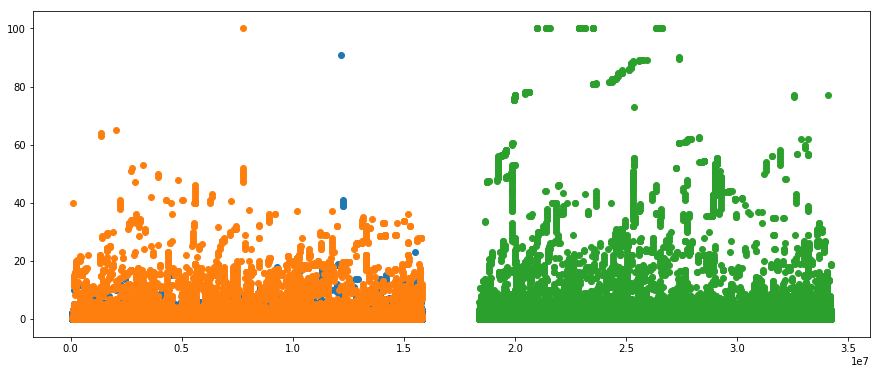

In [69]:
plot_col(df, 'r')

In [70]:
X = train[[x for x in train.columns if 'PCA' in x]+['r']]
y = train.isFraud

In [71]:
X_fit = X[:int(len(X)*0.8)]
y_fit = train.isFraud[:int(len(X)*0.8)]

X_val = X[int(len(X)*0.8):]
y_val = train.isFraud[int(len(X)*0.8):]
gc.collect()

micro_train(X_fit, y_fit, X_val, y_val)
#[1215]	training's auc: 0.916027	valid_0's auc: 0.882617


Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.859802	valid_0's auc: 0.851201
[100]	training's auc: 0.868077	valid_0's auc: 0.855836
[150]	training's auc: 0.872919	valid_0's auc: 0.859519
[200]	training's auc: 0.876485	valid_0's auc: 0.86197
[250]	training's auc: 0.880882	valid_0's auc: 0.864517
[300]	training's auc: 0.884515	valid_0's auc: 0.867377
[350]	training's auc: 0.888111	valid_0's auc: 0.869355
[400]	training's auc: 0.89137	valid_0's auc: 0.871537
[450]	training's auc: 0.893861	valid_0's auc: 0.873041
[500]	training's auc: 0.896593	valid_0's auc: 0.874642
[550]	training's auc: 0.898508	valid_0's auc: 0.876024
[600]	training's auc: 0.900149	valid_0's auc: 0.876962
[650]	training's auc: 0.901844	valid_0's auc: 0.877647
[700]	training's auc: 0.903501	valid_0's auc: 0.878417
[750]	training's auc: 0.904941	valid_0's auc: 0.879065
[800]	training's auc: 0.906198	valid_0's auc: 0.879272
Early stopping, best iteration is:
[774]	training's auc: 0.90

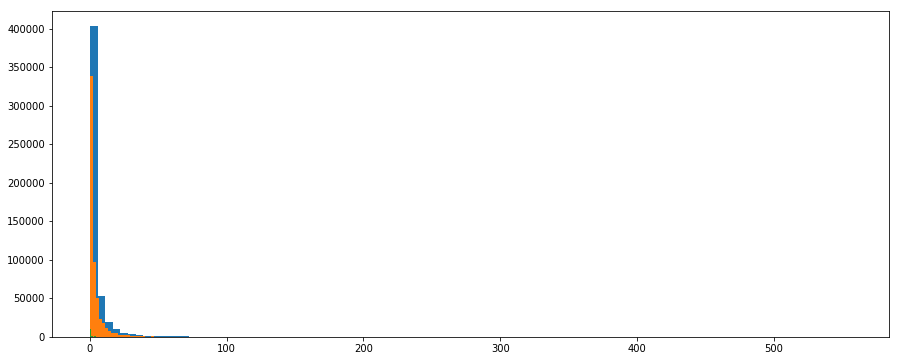

In [45]:
plot_hist_col(df, 'r')

In [20]:
len(list(set(train.columns) & set(train.columns)))

538

In [21]:
for c in new_cat_features:
    df = freq_encoder(df, c, c, 0)
    gc.collect()

In [27]:
list(set([x for x in train.columns if x not in drop_cols]) | set(new_cat_features))

['id_16_fe1',
 'addr2_fe1',
 'V170',
 'V154',
 'V43',
 'D8',
 'M3',
 'id_16',
 'V76',
 'V146',
 'V51',
 'V172',
 'proc_id_30_0',
 'id_04',
 'V94',
 'dayofweek',
 'V249',
 'V252',
 'V54',
 'V92',
 'V257',
 'id_29',
 'V107',
 'V157',
 'card4_fe1',
 'R_emaildomain_0_fe1',
 'PCA_14',
 'PCA_20',
 'id_22_fe1',
 'V24',
 'V39',
 'PCA_21',
 'V26',
 'V72',
 'V191',
 'V173',
 'V14',
 'V239',
 'V125',
 'V28',
 'R_emaildomain_fe1',
 'id_13_fe1',
 'V91',
 'device_version_fe1',
 'PCA_16',
 'V86',
 'V304',
 'R_emaildomain_1_fe1',
 'M8_fe1',
 'V108',
 'V244',
 'V61',
 'V27',
 'day',
 'M5_fe1',
 'V34',
 'V140',
 'V44',
 'V18',
 'id_24_fe1',
 'id_15_fe1',
 'PCA_5',
 'ProductCD',
 'V287',
 'id_19_fe1',
 'V75',
 'PCA_12',
 'proc_id_31_0_fe1',
 'proc_id_31_0',
 'R_emaildomain',
 'M1',
 'PCA_8',
 'card2_fe1',
 'V79',
 'V23',
 'V241',
 'id_34',
 'V184',
 'id_30_fe1',
 'has_identity',
 'V7',
 'device_name',
 'V90',
 'V305',
 'V326',
 'DeviceInfo',
 'V153',
 'M7',
 'V148',
 'PCA_2',
 'PCA_25',
 'addr1_fe1',
 'T

In [28]:
cols = list(set([x for x in train.columns if x not in drop_cols]) | set(new_cat_features))
X = train[cols]
y = train.isFraud

In [29]:
X_fit = X[:int(len(X)*0.8)]
y_fit = train.isFraud[:int(len(X)*0.8)]

X_val = X[int(len(X)*0.8):]
y_val = train.isFraud[int(len(X)*0.8):]
gc.collect()

micro_train(X_fit, y_fit, X_val, y_val)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.877443	valid_0's auc: 0.856422
[100]	training's auc: 0.885161	valid_0's auc: 0.863334
[150]	training's auc: 0.89177	valid_0's auc: 0.869297
[200]	training's auc: 0.898482	valid_0's auc: 0.874257
[250]	training's auc: 0.904878	valid_0's auc: 0.879327
[300]	training's auc: 0.910676	valid_0's auc: 0.883034
[350]	training's auc: 0.916414	valid_0's auc: 0.887384
[400]	training's auc: 0.92114	valid_0's auc: 0.890736
[450]	training's auc: 0.925627	valid_0's auc: 0.893631
[500]	training's auc: 0.929108	valid_0's auc: 0.896321
[550]	training's auc: 0.932041	valid_0's auc: 0.898506
[600]	training's auc: 0.934694	valid_0's auc: 0.900024
[650]	training's auc: 0.936936	valid_0's auc: 0.901722
[700]	training's auc: 0.93905	valid_0's auc: 0.90297
[750]	training's auc: 0.941043	valid_0's auc: 0.904055
[800]	training's auc: 0.942759	valid_0's auc: 0.904961
[850]	training's auc: 0.944355	valid_0's auc: 0.90586
[900]	tra

KeyboardInterrupt: 

In [35]:
cols_d = [x for x in X.columns if 'D' in x and len(x) < 4]

In [41]:
cols_c = [x for x in X.columns if 'C' in x and len(x) < 4]

In [49]:
for c in cols_d:
    X[c] = X[c] / train.groupby(['month','card1'])[c].transform('mean')
    X['{}_std'.format(c)] = X[c] / train.groupby(['month','card1'])[c].transform('std')

In [50]:
for c in cols_c:
    X[c] = X[c] / train.groupby(['month','card1'])[c].transform('mean')
    X['{}_std'.format(c)] = X[c] / train.groupby(['month','card1'])[c].transform('std')

In [51]:
X_fit = X[:int(len(X)*0.8)]
y_fit = train.isFraud[:int(len(X)*0.8)]

X_val = X[int(len(X)*0.8):]
y_val = train.isFraud[int(len(X)*0.8):]
gc.collect()

micro_train(X_fit, y_fit, X_val, y_val)

Training until validation scores don't improve for 50 rounds.
[50]	training's auc: 0.871895	valid_0's auc: 0.851625
[100]	training's auc: 0.882549	valid_0's auc: 0.859349
[150]	training's auc: 0.889327	valid_0's auc: 0.864434
[200]	training's auc: 0.89555	valid_0's auc: 0.868694


KeyboardInterrupt: 

In [41]:
new_cat_features

['PCA_28',
 'PCA_29',
 'C3',
 'D9',
 'V1',
 'V10',
 'V100',
 'V104',
 'V107',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V121',
 'V122',
 'V123',
 'V124',
 'V125',
 'V13',
 'V138',
 'V139',
 'V14',
 'V140',
 'V141',
 'V142',
 'V146',
 'V147',
 'V148',
 'V149',
 'V15',
 'V152',
 'V153',
 'V154',
 'V155',
 'V156',
 'V157',
 'V158',
 'V16',
 'V169',
 'V17',
 'V170',
 'V172',
 'V173',
 'V174',
 'V175',
 'V176',
 'V18',
 'V181',
 'V183',
 'V184',
 'V185',
 'V186',
 'V188',
 'V189',
 'V19',
 'V190',
 'V191',
 'V192',
 'V193',
 'V194',
 'V195',
 'V196',
 'V197',
 'V198',
 'V199',
 'V2',
 'V20',
 'V200',
 'V21',
 'V22',
 'V220',
 'V223',
 'V225',
 'V23',
 'V235',
 'V236',
 'V237',
 'V238',
 'V239',
 'V24',
 'V240',
 'V241',
 'V242',
 'V243',
 'V244',
 'V246',
 'V247',
 'V248',
 'V249',
 'V25',
 'V250',
 'V251',
 'V252',
 'V254',
 'V255',
 'V256',
 'V257',
 'V26',
 'V260',
 'V261',
 'V262',
 'V27',
 'V28

In [77]:
train.V201.value_counts(dropna=False)

NaN     450721
1.0     116412
0.0       9579
2.0       9285
3.0       1922
4.0        860
5.0        422
6.0        270
7.0        186
9.0        178
8.0        134
10.0        98
15.0        80
11.0        64
12.0        44
13.0        40
20.0        27
14.0        24
17.0        17
19.0        17
16.0        16
18.0        14
21.0         9
22.0         9
30.0         6
23.0         6
29.0         6
33.0         6
42.0         5
35.0         5
32.0         5
37.0         5
28.0         5
24.0         5
27.0         5
26.0         5
25.0         5
31.0         4
34.0         4
36.0         4
41.0         4
49.0         3
38.0         3
39.0         3
40.0         3
43.0         2
45.0         2
44.0         2
50.0         1
48.0         1
54.0         1
52.0         1
53.0         1
46.0         1
47.0         1
51.0         1
55.0         1
Name: V201, dtype: int64

In [56]:
list_igual = list()
for i in range(14):
    list_igual.append(train[train.V123 == i].iloc[0,:])

In [35]:
# # def process_data(df):
# print('Processing joined data...')
# df['M'] = df.M1.astype(str) + df.M2.astype(str) + df.M3.astype(str) +\
# df.M4.astype(str) + df.M5.astype(str) + df.M6.astype(str) + \
# df.M7.astype(str) + df.M8.astype(str) + df.M9.astype(str)

# df = df.drop(['D9','id_24','id_25','id_07','id_08','id_21','id_26','id_27','id_23','id_22','dist2'],axis=1)

# df['email'] = df.P_emaildomain.astype(str) + df.R_emaildomain.astype(str)

# #     df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
# #     df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24

# binary_cat_ft = ['card', 'M', 'email', 'dayofweek', 'hour', 'DeviceType',
#                  'proc_id_30_0', 'proc_id_30_1', 'proc_id_31_0']
# encoder = ce.BinaryEncoder(cols=binary_cat_ft)
# df = encoder.fit_transform(df)


# #     df['Transaction_day_of_week'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1) % 7)
# #     df['day'] = np.floor((df['TransactionDT'] / (3600 * 24) - 1))
# #     df['Transaction_hour'] = np.floor(df['TransactionDT'] / 3600) % 24
# #     dict_fe, _d_type = freq_encoder2(df, 'Transaction_day_of_week', 0)
# #     df['Transaction_day_of_week'] = df['Transaction_day_of_week'].apply(lambda x: dict_fe[x]).astype(_d_type)
# #     dict_fe, _d_type = freq_encoder2(df, 'Transaction_hour', 0)
# #     df['Transaction_hour'] = df['Transaction_hour'].apply(lambda x: dict_fe[x]).astype(_d_type)

# id_cols = ['card1', 'card2', 'month']
# cols1 = [x for x in df.columns if 'card' in x and '_fe1' in x]

# cols1 = [x for x in df.columns if 'card' in x and '_fe1' in x]+['month']
# ft = 'N1'
# df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
# dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
# df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

# cols1 = ['addr1', 'addr2']+['month']
# ft = 'N2'
# df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
# dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
# df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

# cols1 = [x for x in df.columns if 'C' in x and 'Product' not in x]+['month']
# ft = 'N3'
# df[ft] = (df.groupby(cols1)['TransactionDT'].transform('count')).fillna(-1)
# dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
# df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

# cols1 = [x for x in df.columns if 'mail' in x]+['month']
# ft = 'N4'
# df[ft] = (df.groupby(cols1)['TransactionDT'].transform('count')).fillna(-1)
# dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
# df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

# cols1 = ['P_emaildomain', 'R_emaildomain', 'addr1']+['month']
# ft = 'N5'
# df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
# dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
# df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)


# cols1 = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6']+['month']
# ft = 'N6'
# df[ft] = df.groupby(cols1)['TransactionDT'].transform('count')
# dict_fe, _d_type = freq_encoder2(df, ft, min_freq = 0)
# df[ft] = df[ft].apply(lambda x: dict_fe[x]).astype(_d_type)

# c_cols = [x for x in df.columns if 'C' in x and x not in ['ProductCD','ProductCD_fe1','ProductCD_fe2']]

# df['R1'] = (np.log1p(df.C13/df.C1)).replace(np.inf, np.nan)
# df['R1_2'] = (np.log1p(df.C2/df.C1)).replace(np.inf, np.nan)
# df['R1_3'] = (np.log1p(df.C3/df.C1)).replace(np.inf, np.nan)
# df['R1_4'] = (np.log1p(df.C4/df.C1)).replace(np.inf, np.nan)
# df['R1_5'] = (np.log1p(df.C5/df.C1)).replace(np.inf, np.nan)

# df['R2'] = (np.log1p(df.D1/df.D15)).replace(np.inf, np.nan)

# df['R3'] = (np.log1p(df.TransactionAmt/df.TransactionAmt.values.mean())).replace(np.inf, np.nan)

# df['R4'] = (np.log1p(df.N3/df.N1)).replace(np.inf, np.nan)

# df['R5'] = (df['D15'] / df.groupby(['card1', 'addr', 'month'])['D15'].transform('std')).replace(np.inf, np.nan)

# df['R6'] = (df['D15'] / df.groupby(['TransactionDT', 'month'])['D15'].transform('std')).replace(np.inf, np.nan)

# df['R7'] = (df.TransactionAmt / df.hour / df.dayofweek).replace(np.inf, np.nan)

# df['R8'] = (df['TransactionAmt'] / df.groupby(['card1', 'addr1', 'month'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

# df['R9'] = (df['TransactionAmt'] / df.groupby(['card1','C13','C1','card2', 'month'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

# df['R10'] = (df['TransactionAmt'] / df.groupby(['card1','addr1','id_01','V258','D1', 'P_emaildomain', 'R_emaildomain', 'month'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

# df['R11'] = (df['TransactionAmt'] / df.groupby(['card1','addr1','P_emaildomain', 'R_emaildomain', 'month'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

# df['R12'] = (df.groupby(['card1','addr1', 'month'])['card1'].transform('mean') * df.groupby(['card1','addr1', 'month'])['card1'].transform('count')).replace(np.inf, np.nan)

# df['R13'] = (df.TransactionAmt / df.groupby(['card1', 'card2','addr1', 'month'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

# df['R14'] = (df.C2 / df.groupby(['card1', 'V258', 'D10', 'month'])['C2'].transform('mean')).replace(np.inf, np.nan)

# df['R15'] = (df.V130 / df.groupby(['addr1', 'card1', 'C10', 'month'])['V130'].transform('std')).replace(np.inf, np.nan)

# df['R16'] = (df.V258 / df.groupby(['addr1', 'card1', 'C10', 'month'])['V258'].transform('std')).replace(np.inf, np.nan)

# df['R17'] = (df.D10 / df.groupby(id_cols)['D10'].transform('std')).replace(np.inf, np.nan)

# df['R18'] = (df.D11 / df.groupby(id_cols)['D11'].transform('std')).replace(np.inf, np.nan)

# df['R19'] = (df.D15 / df.groupby(id_cols)['D15'].transform('std')).replace(np.inf, np.nan)

# df['R20'] = (df.D3 / df.groupby(id_cols)['D3'].transform('std')).replace(np.inf, np.nan)

# df['R21'] = (df.D4 / df.groupby(id_cols)['D4'].transform('std')).replace(np.inf, np.nan)

# df['R22'] = (df.D5 / df.groupby(id_cols)['D5'].transform('std')).replace(np.inf, np.nan)

# df['R23'] = (df.D6 / df.groupby(id_cols)['D6'].transform('std')).replace(np.inf, np.nan)

# df['R24'] = df.D7 * df.groupby(id_cols)['D7'].transform('std')
# df['R24'] = df['R24'].replace(np.inf, np.nan)
# df['R24'] = df['R24']/df['R24'].max()

# df['R25'] = df.D12 * df.groupby(id_cols)['D12'].transform('std')
# df['R25'] = df['R25'].replace(np.inf, np.nan)
# df['R25'] = df['R25']/df['R25'].max()

# df['R26'] = df.D6 * df.groupby(id_cols)['D6'].transform('std')
# df['R26'] = df['R26'].replace(np.inf, np.nan)
# df['R26'] = df['R26']/df['R26'].max()

# df['R27'] = df.D8 * df.groupby(id_cols)['D8'].transform('std')
# df['R27'] = df['R27'].replace(np.inf, np.nan)
# df['R27'] = df['R27']/df['R27'].max()

# df['R28'] = (df.TransactionAmt - df.groupby(id_cols)['TransactionAmt'].shift(1)).replace(np.inf, np.nan)

# df['R29'] = (df.TransactionDT - (df.TransactionDT - df.groupby(id_cols)['TransactionDT'].shift(1))).replace(np.inf, np.nan)

# df['R30'] = (df.dist1 - df.groupby(id_cols)['dist1'].shift(1)).replace(np.inf, np.nan)

# df['R31'] = (df.dist2 - df.groupby(id_cols)['dist2'].shift(1)).replace(np.inf, np.nan)

n = 32
for c in c_cols:
    df['R{}'.format(n)] = (df[c] / df.groupby(id_cols)[c].transform('std')).replace(np.inf, np.nan)
    n += 1

for c in c_cols:
    df['R{}'.format(n)] = (df[c] / df.groupby(id_cols)[c].transform('mean')).replace(np.inf, np.nan)
    n += 1

for c in c_cols:
    df['R{}'.format(n)] = (df[c] / (df.groupby(id_cols)[c].transform('std')/df.groupby(id_cols)[c].transform('mean'))).replace(np.inf, np.nan)
    n += 1


gc.collect()

print('End!\n')

#     return df

End!



In [11]:
def process_data2(train, test):
    print('Processing train and test data...')
    train['M'] = train.M1.astype(str) + train.M2.astype(str) + train.M3.astype(str) +\
    train.M4.astype(str) + train.M5.astype(str) + train.M6.astype(str) + \
    train.M7.astype(str) + train.M8.astype(str) + train.M9.astype(str)

    test['M'] = test.M1.astype(str) + test.M2.astype(str) + test.M3.astype(str) +\
    test.M4.astype(str) + test.M5.astype(str) + test.M6.astype(str) + \
    test.M7.astype(str) + test.M8.astype(str) + test.M9.astype(str)

    train = train.drop(['D9'],axis=1)

    test = test.drop(['D9'],axis=1)

    train['card'] = train.card1.astype(str) + train.card2.astype(str) + train.card3.astype(str) +\
    train.card4.astype(str) + train.card5.astype(str) + train.card6.astype(str)

    test['card'] = test.card1.astype(str) + test.card2.astype(str) + test.card3.astype(str) +\
    test.card4.astype(str) + test.card5.astype(str) + test.card6.astype(str)

    train['email'] = train.P_emaildomain.astype(str) + train.R_emaildomain.astype(str)

    test['email'] = test.P_emaildomain.astype(str) + test.R_emaildomain.astype(str)

    train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
    train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
    train['day'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1))
    
    test['day'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1))
    test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
    test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

    binary_cat_ft = ['card', 'M', 'email', 'Transaction_day_of_week', 'Transaction_hour', 'DeviceType', 'proc_id_30_0',
                     'proc_id_30_1', 'proc_id_31_0']

    encoder = ce.BinaryEncoder(cols=binary_cat_ft)
    encoder.fit(train)
    train = encoder.transform(train)
    test = encoder.transform(test)

    train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
    train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24

    test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
    test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

    id_cols = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain']

    gc.collect()

    cols1 = [x for x in train.columns if 'card' in x and '_fe1' in x]

    cols1 = [x for x in train.columns if 'card' in x and '_fe1' in x]
    ft = 'N1'
    train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
    test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')
    # dict_fe, _d_type = freq_encoder2(train, ft, 0)
    # dict_fe_test = freq_encoder2_test(test, ft, dict_fe)
    # train[ft] = train[ft].apply(lambda x: dict_fe[x]).astype(_d_type)
    # test[ft] = test[ft].apply(lambda x: dict_fe_test[x]).astype(_d_type)

    cols1 = ['addr1', 'addr2']
    ft = 'N2'
    train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
    test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

    cols1 = [x for x in train.columns if 'C' in x and 'Product' not in x]
    ft = 'N3'
    train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
    test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

    cols1 = [x for x in train.columns if 'mail' in x]
    ft = 'N4'
    train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
    test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

    cols1 = ['P_emaildomain', 'R_emaildomain', 'addr1']
    ft = 'N5'
    train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
    test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

    cols1 = ['P_emaildomain', 'R_emaildomain', 'addr1', 'card1']
    ft = 'N6'
    train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
    test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

    cols1 = ['addr1', 'addr2', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'P_emaildomain']
    ft = 'N7'
    train[ft] = train.groupby(cols1)['TransactionDT'].transform('count')
    test[ft] = test.groupby(cols1)['TransactionDT'].transform('count')

    #### V columns

    train['N8'] = train.groupby(cols1)['TransactionDT'].transform('count')
    train['N8'] = (train.N8/train.N8.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N9'] = train.groupby(cols2)['TransactionDT'].transform('count')
    train['N9'] = (train.N9/train.N9.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N10'] = train.groupby(cols3)['TransactionDT'].transform('count')
    train['N10'] = (train.N10/train.N10.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N11'] = train.groupby(cols4)['TransactionDT'].transform('count')
    train['N11'] = (train.N11/train.N11.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N12'] = train.groupby(cols5)['TransactionDT'].transform('count')
    train['N12'] = (train.N12/train.N12.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N13'] = train.groupby(cols6)['TransactionDT'].transform('count')
    train['N13'] = (train.N13/train.N13.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N14'] = train.groupby(cols7)['TransactionDT'].transform('count')
    train['N14'] = (train.N14/train.N14.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N15'] = train.groupby(cols8)['TransactionDT'].transform('count')
    train['N15'] = (train.N15/train.N15.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N16'] = train.groupby(cols9)['TransactionDT'].transform('count')
    train['N16'] = (train.N16/train.N16.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N17'] = train.groupby(cols10)['TransactionDT'].transform('count')
    train['N17'] = (train.N17/train.N17.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N18'] = train.groupby(cols11)['TransactionDT'].transform('count')
    train['N18'] = (train.N18/train.N18.max()).astype(np.float32).replace(np.inf, np.nan)
    train['N19'] = train.groupby(bin_v)['TransactionDT'].transform('count')
    train['N19'] = (train.N19/train.N19.max()).astype(np.float32).replace(np.inf, np.nan)
    n = 20
    for c in V_cols[:4]:
        train['N{}'.format(n)] = (train.groupby(c)['TransactionDT'].transform('std')/train.groupby(c)['TransactionDT'].transform('mean')).replace(np.inf, np.nan)
        n += 1

    test['N8'] = test.groupby(cols1)['TransactionDT'].transform('count')
    test['N8'] = (test.N8/test.N8.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N9'] = test.groupby(cols2)['TransactionDT'].transform('count')
    test['N9'] = (test.N9/test.N9.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N10'] = test.groupby(cols3)['TransactionDT'].transform('count')
    test['N10'] = (test.N10/test.N10.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N11'] = test.groupby(cols4)['TransactionDT'].transform('count')
    test['N11'] = (test.N11/test.N11.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N12'] = test.groupby(cols5)['TransactionDT'].transform('count')
    test['N12'] = (test.N12/test.N12.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N13'] = test.groupby(cols6)['TransactionDT'].transform('count')
    test['N13'] = (test.N13/test.N13.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N14'] = test.groupby(cols7)['TransactionDT'].transform('count')
    test['N14'] = (test.N14/test.N14.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N15'] = test.groupby(cols8)['TransactionDT'].transform('count')
    test['N15'] = (test.N15/test.N15.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N16'] = test.groupby(cols9)['TransactionDT'].transform('count')
    test['N16'] = (test.N16/test.N16.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N17'] = test.groupby(cols10)['TransactionDT'].transform('count')
    test['N17'] = (test.N17/test.N17.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N18'] = test.groupby(cols11)['TransactionDT'].transform('count')
    test['N18'] = (test.N18/test.N18.max()).astype(np.float32).replace(np.inf, np.nan)
    test['N19'] = test.groupby(bin_v)['TransactionDT'].transform('count')
    test['N19'] = (test.N19/test.N19.max()).astype(np.float32).replace(np.inf, np.nan)
    n = 20
    for c in V_cols[:4]:
        test['N{}'.format(n)] = (test.groupby(c)['TransactionDT'].transform('std')/test.groupby(c)['TransactionDT'].transform('mean')).replace(np.inf, np.nan)
        n += 1


    c_cols = [x for x in train.columns if 'C' in x and x not in ['ProductCD','ProductCD_fe1','ProductCD_fe2']]

    train['R1'] = (np.log1p(train.C13/train.C1)).replace(np.inf, np.nan)

    train['R2'] = (np.log1p(train.D1/train.D15)).replace(np.inf, np.nan)

    train['R3'] = (np.log1p(train.TransactionAmt/train.TransactionAmt.values.mean())).replace(np.inf, np.nan)

    train['R4'] = (np.log1p(train.N3/train.N1)).replace(np.inf, np.nan)

    train['R5'] = (train['D15'] / train.groupby(['card1', 'addr1'])['D15'].transform('std')).replace(np.inf, np.nan)

    train['R6'] = (train['D15'] / train.groupby(['TransactionDT'])['D15'].transform('std')).replace(np.inf, np.nan)

    train['R7'] = (train.TransactionAmt / train.Transaction_hour / train.Transaction_day_of_week).replace(np.inf, np.nan)

    train['R8'] = (train['TransactionAmt'] / train.groupby(['card1', 'addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    train['R9'] = (train['TransactionAmt'] / train.groupby(['card1','C13','C1','card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    train['R10'] = (train['TransactionAmt'] / train.groupby(['card1','addr1','id_01','V258','D1', 'P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    train['R11'] = (train['TransactionAmt'] / train.groupby(['card1','addr1','P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    train['R12'] = (train.groupby(['card1','addr1'])['card1'].transform('mean') * train.groupby(['card1','addr1'])['card1'].transform('count')).replace(np.inf, np.nan)

    train['R13'] = (train.TransactionAmt / train.groupby(['card1', 'card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    train['R14'] = (train.C2 / train.groupby(['card1', 'V258', 'D10'])['C2'].transform('mean')).replace(np.inf, np.nan)

    train['R15'] = (train.V130 / train.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V130'].transform('std')).replace(np.inf, np.nan)

    train['R16'] = (train.V258 / train.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V258'].transform('std')).replace(np.inf, np.nan)

    train['R17'] = (train.D10 / train.groupby(id_cols)['D10'].transform('std')).replace(np.inf, np.nan)

    train['R18'] = (train.D11 / train.groupby(id_cols)['D11'].transform('std')).replace(np.inf, np.nan)

    train['R19'] = (train.D15 / train.groupby(id_cols)['D15'].transform('std')).replace(np.inf, np.nan)

    train['R20'] = (train.D3 / train.groupby(id_cols)['D3'].transform('std')).replace(np.inf, np.nan)

    train['R21'] = (train.D4 / train.groupby(id_cols)['D4'].transform('std')).replace(np.inf, np.nan)

    train['R22'] = (train.D5 / train.groupby(id_cols)['D5'].transform('std')).replace(np.inf, np.nan)

    train['R23'] = (train.D6 / train.groupby(id_cols)['D6'].transform('std')).replace(np.inf, np.nan)

    train['R24'] = train.D7 * train.groupby(id_cols)['D7'].transform('std')
    train['R24'] = train['R24'].replace(np.inf, np.nan)
    train['R24'] = train['R24']/train['R24'].max()

    train['R25'] = train.D12 * train.groupby(id_cols)['D12'].transform('std')
    train['R25'] = train['R25'].replace(np.inf, np.nan)
    train['R25'] = train['R25']/train['R25'].max()

    train['R26'] = train.D6 * train.groupby(id_cols)['D6'].transform('std')
    train['R26'] = train['R26'].replace(np.inf, np.nan)
    train['R26'] = train['R26']/train['R26'].max()

    train['R27'] = train.D8 * train.groupby(id_cols)['D8'].transform('std')
    train['R27'] = train['R27'].replace(np.inf, np.nan)
    train['R27'] = train['R27']/train['R27'].max()

    train['R28'] = (train.TransactionAmt - train.groupby(id_cols)['TransactionAmt'].shift(1)).replace(np.inf, np.nan)

    train['R29'] = (train.TransactionDT - (train.TransactionDT - train.groupby(id_cols)['TransactionDT'].shift(1))).replace(np.inf, np.nan)

    train['R30'] = (train.dist1 - train.groupby(id_cols)['dist1'].shift(1)).replace(np.inf, np.nan)

    train['R31'] = (train.dist2 - train.groupby(id_cols)['dist2'].shift(1)).replace(np.inf, np.nan)

    n = 32
    for c in c_cols:
        train['R{}'.format(n)] = (train[c] / train.groupby(id_cols)[c].transform('std')).replace(np.inf, np.nan)
        n += 1

    for c in c_cols:
        train['R{}'.format(n)] = (train[c] / train.groupby(id_cols)[c].transform('mean')).replace(np.inf, np.nan)
        n += 1

    for c in c_cols:
        train['R{}'.format(n)] = (train[c] / (train.groupby(id_cols)[c].transform('std')/train.groupby(id_cols)[c].transform('mean'))).replace(np.inf, np.nan)
        n += 1


    test['R1'] = (np.log1p(test.C13/test.C1)).replace(np.inf, np.nan)

    test['R2'] = (np.log1p(test.D1/test.D15)).replace(np.inf, np.nan)

    test['R3'] = (np.log1p(test.TransactionAmt/test.TransactionAmt.values.mean())).replace(np.inf, np.nan)

    test['R4'] = (np.log1p(test.N3/test.N1)).replace(np.inf, np.nan)

    test['R5'] = (test['D15'] / test.groupby(['card1', 'addr1'])['D15'].transform('std')).replace(np.inf, np.nan)

    test['R6'] = (test['D15'] / test.groupby(['TransactionDT'])['D15'].transform('std')).replace(np.inf, np.nan)

    test['R7'] = (test.TransactionAmt / test.Transaction_hour / test.Transaction_day_of_week).replace(np.inf, np.nan)

    test['R8'] = (test['TransactionAmt'] / test.groupby(['card1', 'addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    test['R9'] = (test['TransactionAmt'] / test.groupby(['card1','C13','C1','card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    test['R10'] = (test['TransactionAmt'] / test.groupby(['card1','addr1','id_01','V258','D1', 'P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    test['R11'] = (test['TransactionAmt'] / test.groupby(['card1','addr1','P_emaildomain', 'R_emaildomain'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    test['R12'] = (test.groupby(['card1','addr1'])['card1'].transform('mean') * test.groupby(['card1','addr1'])['card1'].transform('count')).replace(np.inf, np.nan)

    test['R13'] = (test.TransactionAmt / test.groupby(['card1', 'card2','addr1'])['TransactionAmt'].transform('std')).replace(np.inf, np.nan)

    test['R14'] = (test.C2 / test.groupby(['card1', 'V258', 'D10'])['C2'].transform('mean')).replace(np.inf, np.nan)

    test['R15'] = (test.V130 / test.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V130'].transform('std')).replace(np.inf, np.nan)

    test['R16'] = (test.V258 / test.groupby(['addr1', 'card1', 'C10', 'Transaction_hour', 'Transaction_day_of_week'])['V258'].transform('std')).replace(np.inf, np.nan)

    test['R17'] = (test.D10 / test.groupby(id_cols)['D10'].transform('std')).replace(np.inf, np.nan)

    test['R18'] = (test.D11 / test.groupby(id_cols)['D11'].transform('std')).replace(np.inf, np.nan)

    test['R19'] = (test.D15 / test.groupby(id_cols)['D15'].transform('std')).replace(np.inf, np.nan)

    test['R20'] = (test.D3 / test.groupby(id_cols)['D3'].transform('std')).replace(np.inf, np.nan)

    test['R21'] = (test.D4 / test.groupby(id_cols)['D4'].transform('std')).replace(np.inf, np.nan)

    test['R22'] = (test.D5 / test.groupby(id_cols)['D5'].transform('std')).replace(np.inf, np.nan)

    test['R23'] = (test.D6 / test.groupby(id_cols)['D6'].transform('std')).replace(np.inf, np.nan)

    test['R24'] = test.D7 * test.groupby(id_cols)['D7'].transform('std')
    test['R24'] = test['R24'].replace(np.inf, np.nan)
    test['R24'] = test['R24']/test['R24'].max()

    test['R25'] = test.D12 * test.groupby(id_cols)['D12'].transform('std')
    test['R25'] = test['R25'].replace(np.inf, np.nan)
    test['R25'] = test['R25']/test['R25'].max()

    test['R26'] = test.D6 * test.groupby(id_cols)['D6'].transform('std')
    test['R26'] = test['R26'].replace(np.inf, np.nan)
    test['R26'] = test['R26']/test['R26'].max()

    test['R27'] = test.D8 * test.groupby(id_cols)['D8'].transform('std')
    test['R27'] = test['R27'].replace(np.inf, np.nan)
    test['R27'] = test['R27']/test['R27'].max()

    test['R28'] = (test.TransactionAmt - test.groupby(id_cols)['TransactionAmt'].shift(1)).replace(np.inf, np.nan)

    test['R29'] = (test.TransactionDT - (test.TransactionDT - test.groupby(id_cols)['TransactionDT'].shift(1))).replace(np.inf, np.nan)

    test['R30'] = (test.dist1 - test.groupby(id_cols)['dist1'].shift(1)).replace(np.inf, np.nan)

    test['R31'] = (test.dist2 - test.groupby(id_cols)['dist2'].shift(1)).replace(np.inf, np.nan)

    n = 32
    for c in c_cols:
        test['R{}'.format(n)] = (test[c] / test.groupby(id_cols)[c].transform('std')).replace(np.inf, np.nan)
        n += 1

    for c in c_cols:
        test['R{}'.format(n)] = (test[c] / test.groupby(id_cols)[c].transform('mean')).replace(np.inf, np.nan)
        n += 1

    for c in c_cols:
        test['R{}'.format(n)] = (test[c] / (test.groupby(id_cols)[c].transform('std')/test.groupby(id_cols)[c].transform('mean'))).replace(np.inf, np.nan)
        n += 1

    
    gc.collect()
    
    print('End!\n')
    
    return train, test

In [36]:
# df = process_data(df)

In [38]:
new_cols = list(set(df.columns) - set(old_cols))
len(new_cols)

149

In [41]:
new_cols = list(set(df.columns) - set(old_cols))
len(new_cols)

146

In [48]:
dict_types = reduce_memory2(train[new_cols])

Reduce_memory...


In [39]:
dict_types = reduce_memory2(df[new_cols])

Reduce_memory...


In [46]:
# for i, j in zip(dict_types.keys(), dict_types.values()):
#     train[i] = train[i].astype(j)

In [40]:
for i, j in zip(dict_types.keys(), dict_types.values()):
    df[i] = df[i].astype(j)

In [42]:
dict(df.dtypes)

{'C1': dtype('float16'),
 'C10': dtype('float16'),
 'C11': dtype('float16'),
 'C12': dtype('float16'),
 'C13': dtype('float16'),
 'C14': dtype('float16'),
 'C2': dtype('float16'),
 'C3': dtype('float16'),
 'C4': dtype('float16'),
 'C5': dtype('float16'),
 'C6': dtype('float16'),
 'C7': dtype('float16'),
 'C8': dtype('float16'),
 'C9': dtype('float16'),
 'D1': dtype('float16'),
 'D10': dtype('float16'),
 'D11': dtype('float16'),
 'D12': dtype('float16'),
 'D13': dtype('float16'),
 'D14': dtype('float16'),
 'D15': dtype('float16'),
 'D2': dtype('float16'),
 'D3': dtype('float16'),
 'D4': dtype('float16'),
 'D5': dtype('float16'),
 'D6': dtype('float16'),
 'D7': dtype('float16'),
 'D8': dtype('float16'),
 'DeviceInfo': dtype('uint16'),
 'DeviceType_0': dtype('int8'),
 'DeviceType_1': dtype('int8'),
 'DeviceType_2': dtype('int8'),
 'M1': dtype('uint8'),
 'M2': dtype('uint8'),
 'M3': dtype('uint8'),
 'M4': dtype('uint8'),
 'M5': dtype('uint8'),
 'M6': dtype('uint8'),
 'M7': dtype('uint8'),


In [ ]:
# drop_cols = ['D10', 'D11', 'D12', 'D15', 'D3', 'D4',
#             'D5', 'D6', 'D7', 'D8']

In [ ]:
# df = df[[x for x in df.columns if x not in drop_cols]]

In [ ]:
# df = df.replace(np.inf, np.nan)

In [43]:
train = df.iloc[:train_index, :]
test = df.iloc[train_index:, :]
train.shape, test.shape

((590540, 724), (506691, 724))

In [44]:
train.to_csv(data_folder+'/train_ft_eng_3.csv', header=True, index=None)
print('train guardado')
test.to_csv(data_folder+'/test_ft_eng_3.csv', header=True, index=None)
print('test guardado')

train guardado
test guardado


In [53]:
train.shape, test.shape

((270901, 716), (221908, 716))

In [54]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,R64,R65,R66,R67,R68,R69,R70,R71,R72,R73
0,0,86400,68.5,0,1749,12,0,3,35,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,0,139,31,0,1,3,1,...,0.0,NaN,NaN,0.0,0.000,0.0,1.385742,NaN,0.726074,1.069336
2,0,86469,59.0,0,101,3,0,0,2,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.0,0,17,20,0,1,4,0,...,NaN,13.851562,NaN,0.0,5.125,0.0,4.273438,NaN,56.156250,10.195312
4,0,86506,50.0,3,5782,7,0,1,3,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
